In [ ]:
# ------------------------------------------------------------------------------
# Authors: Andreas Nilsson, Anouka Ranby, Erik Rosvall (All part of ADS program)
# Date: 23 Jan 2022
# Description: Decision Trees - Applied Machine Learning, DIT867
# ------------------------------------------------------------------------------

## Task 2: Decision trees and random forests
In the previous assignment, in one of the optional tasks (Task 4, step 4) we investigated the performance of a regression model as a function of the depth of the decision trees.

### Underfitting and overfitting in decision tree classifiers.

As the first step, please reproduce this experiment for this dataset, but now using scikit-learn's DecisionTreeClassifier instead of your own regression model. Of course, you should use an evaluation metric for classification, not the mean squared error. Do you see a similar effect now?

In [ ]:
# Import required libs
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV

In [ ]:
# Import csv file for Training data
train = pd.read_csv('adult_train.csv')

# Import csv file for Test data
test = pd.read_csv('adult_test.csv')

# Split into input part X and output part Y.
# convert X data to dict - creates a list of dicts 
# where each row's (person's) information is gathered in one dict, 
Xtrain_dicts = train.drop('target', axis=1).to_dict('records')
Xtest_dicts = test.drop('target', axis=1).to_dict('records')
Ytrain = train['target']
Ytest = test['target']

In [ ]:
# show first person's information
Xtrain_dicts[:1] 

[{'age': 27,
  'workclass': 'Private',
  'education': 'Some-college',
  'education-num': 10,
  'marital-status': 'Divorced',
  'occupation': 'Adm-clerical',
  'relationship': 'Unmarried',
  'race': 'White',
  'sex': 'Female',
  'capital-gain': 0,
  'capital-loss': 0,
  'hours-per-week': 44,
  'native-country': 'United-States'}]

In [ ]:
# create d DictVectorizer 
dv = DictVectorizer()

# one-hot encode the list with all dicts
Xtrain_encoded = dv.fit_transform(Xtrain_dicts)
Xtest_encoded = dv.transform(Xtest_dicts)

In [ ]:
def best_model_depth(min_d, max_d, Xtrain, Ytrain, Xtest, Ytest):
    """
    Tests different depth of tree and return accuracy scores for test and train for all depths
    """
    # empty lists to store accuracy score for train and test
    scores_train = []
    scores_test = []
    
    #test depth between 1-10 (inclusive)
    for i in range(min_d, max_d): 
        
        # Create Decision Tree Classifier object
        model = DecisionTreeClassifier(max_depth=i)
        # Fit/train model with training data
        model.fit(Xtrain, Ytrain)
                
        # accuracy for train
        train_acc = accuracy_score(Ytrain, model.predict(Xtrain))

        # accuracy for test data
        test_acc = accuracy_score(Ytest, model.predict(Xtest))

        # append performance scores for each iteration
        scores_train.append(train_acc)
        scores_test.append(test_acc)
    
    return scores_train, scores_test

In [ ]:
# set min and max tree depth
min_d = 1 #min tree depth
max_d = 21 #max tree depth

# iterate over tre depths and collect the performance
train_acc, test_acc = best_model_depth(min_d, max_d, Xtrain_encoded, Ytrain, Xtest_encoded, Ytest)

In [ ]:
# store best results from test data
best_acc = max(test_acc)
best_depth = test_acc.index(max(test_acc))+1

# print result
print("---\nBest Accuracy for Test data was",best_acc,"with a max depth of",best_depth)

---
Best Accuracy for Test data was 0.8608807812787912 with a max depth of 10


In [ ]:
def plot_train_test_accuracy(min_range, max_range, train_scores, test_scores):
    """plot the performance of test and training scores"""
    plt.figure(figsize=(10,6))
    plt.plot(range(min_range,max_range), train_scores, label = "Train", color='green')
    plt.plot(range(min_range,max_range), test_scores, label = "Test", color='blue')
    plt.title("Train vs. Test Accuracy by Tree Depth (DecisionTreeClassification)")
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(range(min_range,max_range,1))
    plt.grid()
    plt.show()

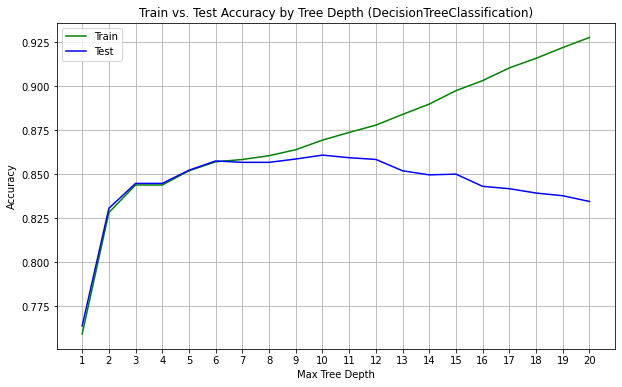

In [ ]:
plot_train_test_accuracy(min_d, max_d, train_acc, test_acc)

##### Comments:

In the plot above we can see the max tree depth on the x-axis and the accuracy score on the y-axis (without cross validation).

The blue line represent the performance of a Classification Decision Tree on the unseen test data while the green line show the performance of the training data.

As we can see the two lines starts to seperate after the max tree depth of 7. The performance continue to increase for the training data as the model gets more familiar with the data points and overfit. The accuracy for the test data is at its highest when the tree depths is 10, then it starts to decrease again.

### Underfitting and overfitting in random forest classifiers.

Replace the DecisionTreeClassifier with a RandomForestClassifier.

The hyperparameter n_estimators defines the number of decision trees used in ensemble.

Investigate how the underfitting/overfitting curve is affected by the number of trees. You can investigate ensemble sizes ranging from 1 up until a few hundred. (Clarification: you will produce one such curve for each ensemble size. The x axis still represents the maximal tree depth.)

Hint. These experiments can take some time to run. When n_estimators is large, you can reduce the training time quite a bit by adjusting the hyperparameter n_jobs, which will train several trees in parallel. By default, only one CPU core is used, but if you set n_jobs=-1, all cores will be used.

##### Random Forest Classifier hyperparameter settings
Random forest classifier below uses a subset of features in comparison to the decision tree classifier above that uses all features. The max features is not specified as hyperparemeters below in the RFC and therefore defauls into 'auto', which is the same as 'sqrt' meaning: max_features=sqrt(n_features). 

The RFC also uses a subset of data points from the training data since 'bootstrap' parameter is not specified it defaults to 'True', which means that it samples data points by the bootstrapping method.

By default the gini score is also used as criterion to measure the quality of the split.

In [ ]:
def best_model_depth2(no_trees, min_d, max_d, Xtrain, Ytrain, Xtest, Ytest):
    """
    Tests different depth of tree and return accuracy scores for test and train for all depths
    """
    # empty lists to store accuracy score for train and test
    scores_train = []
    scores_test = []
    
    #test depth between 1-10 (inclusive)
    for i in range(min_d, max_d): 
        
        # Create Decision Tree Classifier object
        model = RandomForestClassifier(max_depth=i, n_estimators=no_trees, random_state=0, n_jobs=-1)
        
        start = time.time() # start timer
        # Fit/train model with training data
        model.fit(Xtrain,Ytrain)
        end = time.time() # end timer
        train_time = end - start
                
        # accuracy for train
        train_acc = accuracy_score(Ytrain, model.predict(Xtrain))

        # accuracy for test data
        test_acc = accuracy_score(Ytest, model.predict(Xtest))

        # append performance scores for each iteration
        scores_train.append(train_acc)
        scores_test.append(test_acc)
    
    return train_time, scores_train, scores_test

In [ ]:
def plot_train_test_accuracy2(no_trees, min_range, max_range, train_scores, test_scores):
    """plot the performance of test and training scores"""
    plt.figure(figsize=(10,6))
    plt.plot(range(min_range,max_range), train_scores, label = "Train", color='green')
    plt.plot(range(min_range,max_range), test_scores, label = "Test", color='blue')
    plt.title("RandomForestClassification ({} tree/s)\nTrain vs. Test Accuracy by Max Tree Depth".format(no_trees))
    plt.xlabel("Max Tree Depth")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.xticks(range(min_range,max_range,1))
    plt.grid()
    plt.show()

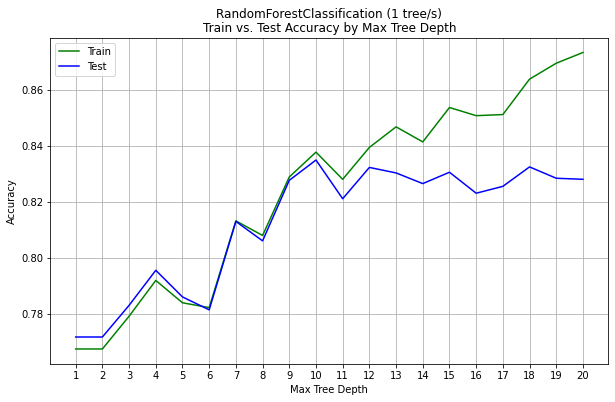

---
Best Accuracy for Test data with 1 tree/s was 0.8349609974817271 with a max depth of 10

Time to train (sek): 0.24873566627502441


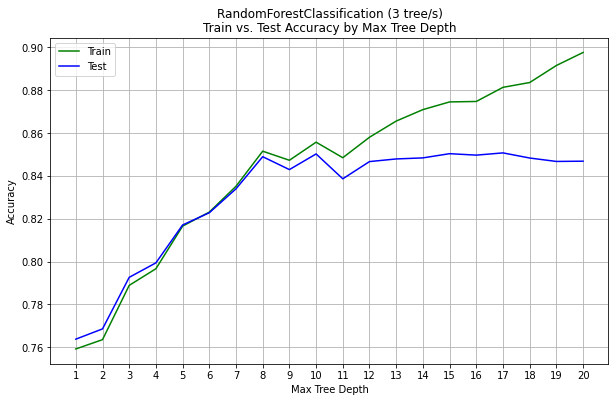

---
Best Accuracy for Test data with 3 tree/s was 0.8507462686567164 with a max depth of 17

Time to train (sek): 0.5446717739105225


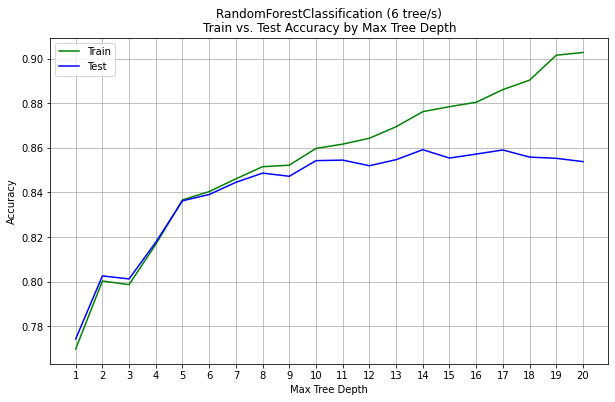

---
Best Accuracy for Test data with 6 tree/s was 0.8591609851974694 with a max depth of 14

Time to train (sek): 1.0810370445251465


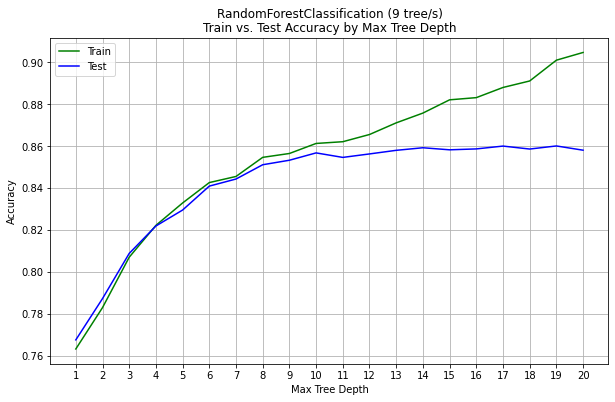

---
Best Accuracy for Test data with 9 tree/s was 0.8600208832381303 with a max depth of 19

Time to train (sek): 1.4629979133605957


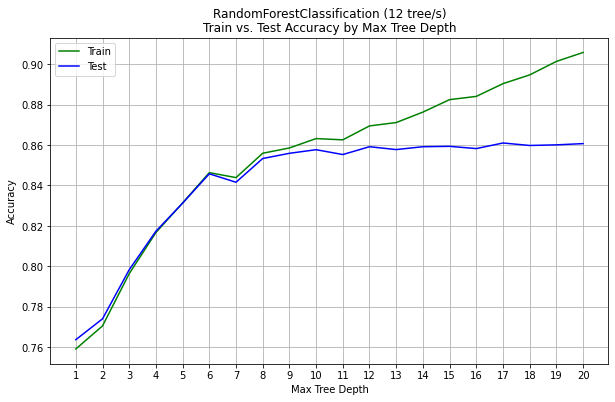

---
Best Accuracy for Test data with 12 tree/s was 0.8610036238560285 with a max depth of 17

Time to train (sek): 1.8607146739959717


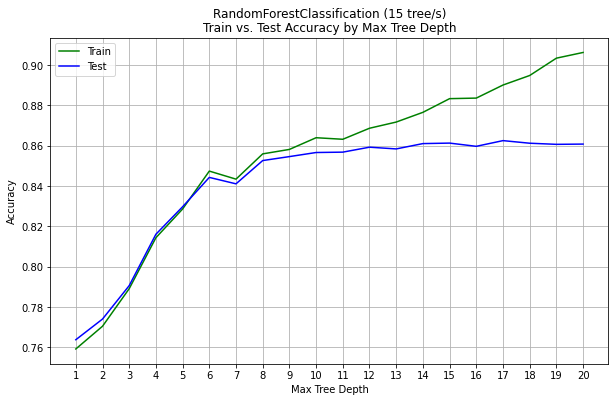

---
Best Accuracy for Test data with 15 tree/s was 0.8625391560714943 with a max depth of 17

Time to train (sek): 2.3548035621643066


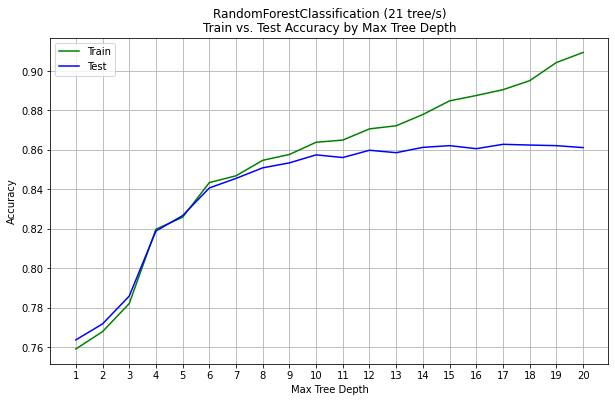

---
Best Accuracy for Test data with 21 tree/s was 0.8628462625145875 with a max depth of 17

Time to train (sek): 3.171419858932495


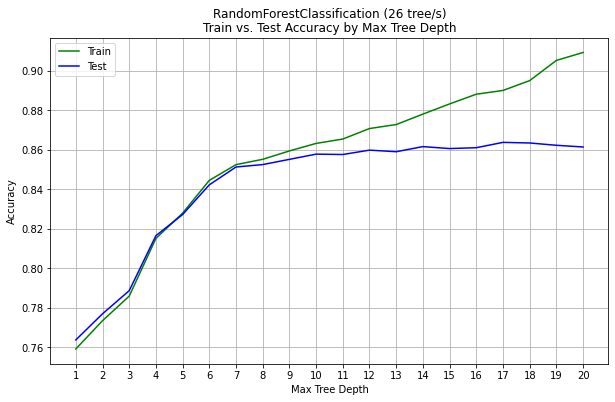

---
Best Accuracy for Test data with 26 tree/s was 0.863767581843867 with a max depth of 17

Time to train (sek): 3.887110948562622


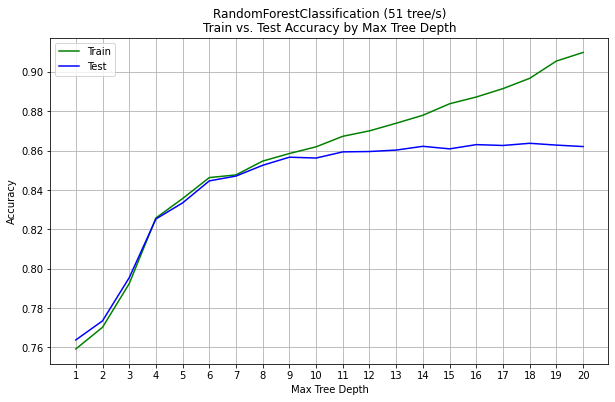

---
Best Accuracy for Test data with 51 tree/s was 0.8637061605552484 with a max depth of 18

Time to train (sek): 7.800159454345703


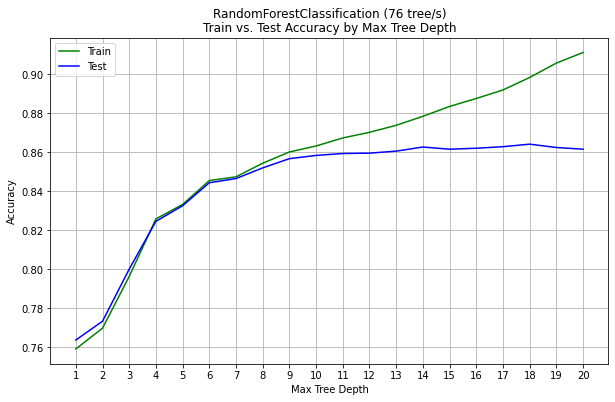

---
Best Accuracy for Test data with 76 tree/s was 0.8641975308641975 with a max depth of 18

Time to train (sek): 11.26054072380066


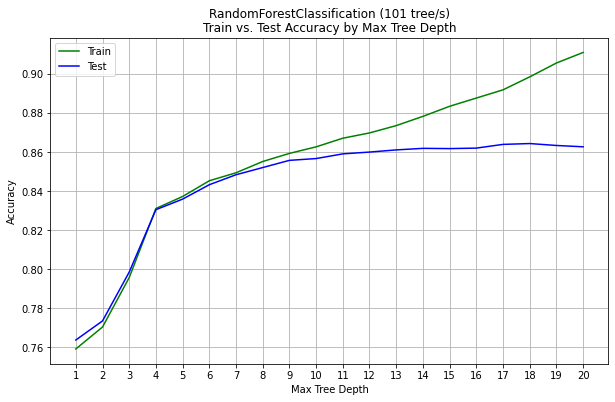

---
Best Accuracy for Test data with 101 tree/s was 0.8643203734414348 with a max depth of 18

Time to train (sek): 15.169860601425171


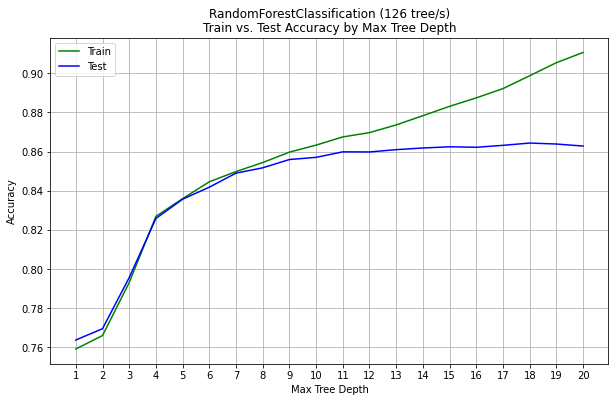

---
Best Accuracy for Test data with 126 tree/s was 0.8643817947300534 with a max depth of 18

Time to train (sek): 18.558351039886475


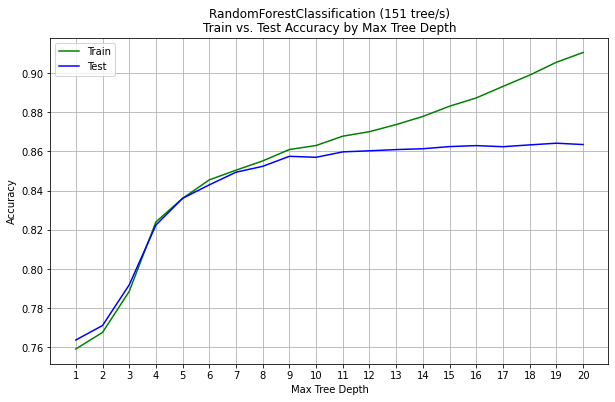

---
Best Accuracy for Test data with 151 tree/s was 0.8641975308641975 with a max depth of 19

Time to train (sek): 21.867859363555908


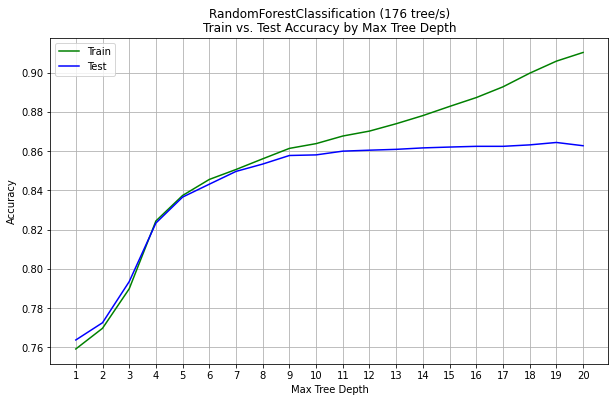

---
Best Accuracy for Test data with 176 tree/s was 0.8643817947300534 with a max depth of 19

Time to train (sek): 25.396762371063232


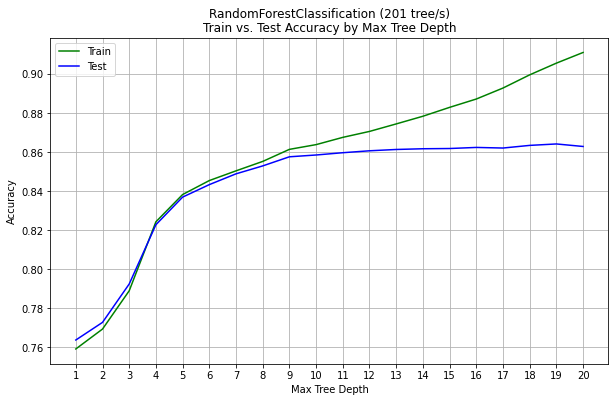

---
Best Accuracy for Test data with 201 tree/s was 0.8641361095755788 with a max depth of 19

Time to train (sek): 28.92926001548767


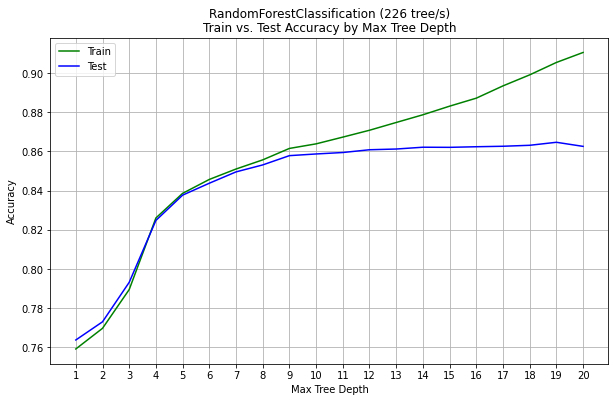

---
Best Accuracy for Test data with 226 tree/s was 0.8646274798845279 with a max depth of 19

Time to train (sek): 32.33789896965027


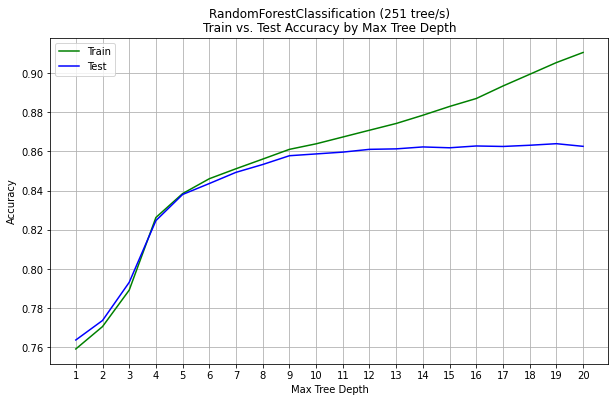

---
Best Accuracy for Test data with 251 tree/s was 0.8639518457097229 with a max depth of 19

Time to train (sek): 36.138707876205444


In [ ]:
# number of trees to test in ensemble
trees = [1,3,6,9,12,15,21,26,51,76,101,126,151,176,201,226,251]

# iterate over different number of trees in ensemble
for i in trees:
    # find best model for number of trees
    train_time, train_acc, test_acc = best_model_depth2(i, min_d, max_d, Xtrain_encoded, Ytrain, Xtest_encoded, Ytest)
    # plot results
    plot_train_test_accuracy2(i, min_d, max_d, train_acc, test_acc)
    # store best results from test data
    best_acc = max(test_acc)
    best_depth = test_acc.index(max(test_acc))+1
    # print result
    print("---\nBest Accuracy for Test data with {} tree/s was {} with a max depth of {}".format(i, best_acc, best_depth))
    print("Time to train (sek):",train_time)

##### Comments:

The above charts show the max tree depth on the x-axis and the accuracy score on the y-axis. The blue line represent the performance on the unseen test data while the green line represent the performance of the training data. 

**Difference between DecisionTreeClassifier and RandomForestClassifier (RFC)**:

The main difference between the DTC and the RFC with 1 tree is that RFC has a more volatile accuracy performance zig-zaging its way up while the DCT has a strong growth in performance in the beginning and smoother curves. The reason we are seeing this difference is because we are randomly selecting a number of features for the RFC, which is different from the DTC that make use of all features. 

The line for test data for the DTC increases, reached as maximum and decreases again, which is different from the RFC that seems to have more of a stagnating line (even though it's a bit hard to tell as it is so volatile but is more clear as the number of trees grow)

There best accuracy performance for the DTC and the RFC with 1 tree on the unseen test data was not far away from each other and at the same max tree depth:
- DTC = 86% at depth 10
- RFC = 83% at depth 10

As expected, the behaviour of that the lines starts to grow apart, is the same for both models but it starts at a greater tree depth for the RFC (10) in comparison to the DTC (7).

**Curve development for RandomForestClassifier**: 

The curve seems to grow smoother and smoother as the number of trees increase. Additionally, as mentioned above, the curve for the test accuracy increases quickly by the number of max tree depth and then seem to stagnate. This is different from the behaviour observed for the DTC that reached a maximum and decreases again. 


**Accuracy on test data**: 

As the number of tree in the RFC ensemble grows tha line also grows closer to about 86% accuracy where it seems to stagnate or at least show little difference after a max tree depth of 9-10. The first chart with only 1 tree in it does not quite reach as high in accuracy performance (only 83%) as the other models containing more trees (naturally a collection of trees is the central part and strenghts RFC) showing average results of all trees. The best score is measured at deeper tree levels between 17 and 19 in depth, which is different from the one tree models (DTC & RFC 1 tree) with the best accuracy at 10 max tree depth.


**Training Time**: 

Naturally as the ensemble size grows from 1 tree to 251 trees the training time takes longer and longer having more trees to train with each tree having a max depth and features.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a6ba0eaf-97fa-4fd0-ab2f-858132e990c1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>